<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Create-a-Network-Graph" data-toc-modified-id="Create-a-Network-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a Network Graph</a></span></li><li><span><a href="#Cluster-the-nodes-into-communities" data-toc-modified-id="Cluster-the-nodes-into-communities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cluster the nodes into communities</a></span></li></ul></div>

# Import Packages

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data
Let's load in an example dataset that I have pre-prepared. The data set is a collection of edges and associated weights that have been randomly generated.

In [546]:
df = pd.read_csv('example_data.csv')
df.head()

,content1,content2,weight
0,content1,content61,0.919356
1,content39,content72,0.391961
2,content84,content48,0.074428
3,content55,content24,0.668009
4,content84,content68,0.331193


Our dataset contains 3 columns: 'node1', 'node2' and 'weight'. The node columns are lists of tuples that contain the name of 2 pieces of content; this represents an edge. The edges are weight agnostic so an edge can equally be expressed as node1-node2 or node2-node1. I have deduplicated the edges already. The weight column tells us how strongly the two pieces of content are related. A large value indicates a strong connection while a low value indicates only a weak similarity between the two content items. Let's extract these into 4 lists. We need a list of weights, a list of edges as tuples, a list of weighted edges that contains both nodes and their weight, and a list of unique nodes.

In [537]:
list_of_weights = list(df['weight'])
list_of_edges = list(zip(df['node1'], df['node2']))
list_of_weighted_edges = list(zip(df['node1'], df['node2'], df['weight']))
list_of_nodes = list(set(df['node1']).union(set(df['node2'])))

# Create a Network Graph
Our first job is to create a network graph. This means combining all of our edges together in someway. For this we'll use the package networkx, which I have imported as nx. Once the package is installed we need to initiate an instance of a Graph.

In [538]:
import networkx as nx
# Create an instance of a graph
G = nx.Graph()

Then all we need to do to to create our graph is to add the edges and nodes.

In [539]:
# Add the nodes
G.add_nodes_from(list_of_nodes)
# Add the edges
G.add_edges_from(list_of_edges)
# Add some additional attributes
G.add_weighted_edges_from(list_of_weighted_edges)

Now we can plot our network graph using the draw() method in networkx. There are several different layouts for where we position the nodes, I like spring_layout. spring_layout positions the nodes so that the relative distance between nodes is roughly representative of the weights between them. In 2 dimensions, it isn't possible to do this exactly and so the process isn't deterministic and will change each time you calculate it. To generate the x-y coordinates for our graph we just have to use this one liner:

In [540]:
pos = nx.spring_layout(G, dim=2)

Try using nx.circular_layout() yourself to see how different it looks to spring_layout. Each layout takes 2 inputs; our graph, G, and the number of dimensions that we want our graph to be displayed in. In this case we want to set dim = 2. The output, pos, is a dictionary with our node labels (content names in this case) as keys and the corresponding x and y coordinates for that node as the values.

Now to plot the graph we just need to pass our graph, G, and the dictionary pos into nx.draw. I've also chosen to specify the edge colour and reduce the node size to make the graph look better.

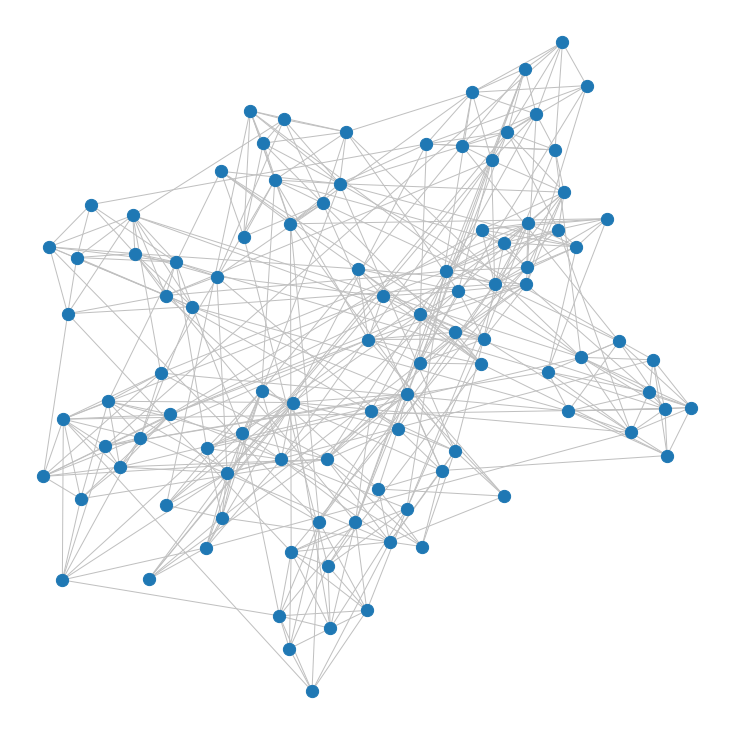

In [541]:
fig = plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    edge_color=['silver'] * len(list_of_edges),
    node_size=150,
)
# fig.savefig('../figures/unpartitioned_graph.png', dpi = 500)

You can already tell that there are clearly individual communities of nodes in our graph that are positioned close together but far from the other nodes in the graph. I will now explain how we can apply Louvain clustering to formally identify these communities.

# Cluster the nodes into communities
For this, we will use the community package so let's import it. Partitioning our network graph is incredibly simply and requires just the following line:

In [542]:
import community
partition = community.best_partition(G)

The output from community.best_partition() is a dictionary that has our node names as keys and an integer as the value that tells us which community the node belongs to. There is no meaning attached to the actual number assigned to an individual node and this will change each time you run it. The important thing is which nodes have the same number associate with them. The process for determining the communities is non-deterministic and so there maybe slight differences each time you run it; some of the nodes that don't have a strong connection to a community may swap between 2 or more nearby communities.

To assess how well our network has been clustered we can use the modularity() method in the community package and we just need to provide the partition dictionary and our graph, G. The result is a number between -1 and 1. A value of 1 indicates discrete communities that have no edges linking them to nodes from other communities. This is unlikely to ever occur in reality. Typically, values of around 0.7 represent a decent partitioning.

In [543]:
modularity = community.modularity(partition, G)
modularity

0.8115740078801968

In this case, we have a modularity of arounf 0.7. It's also worth noting that because the partitioning isn't deterministic, the value of the modularity can fluctuate between different partitions of the same data. It is therefore worthwhile iterating the process of partitioning the graph and taking the one with the highest modularity.

The modularity is useful in telling us mathematically how well our graph has been partitioned but a good sanity check is to replot the graph but colour the nodes according to their community. Firstly, we're going to pass cmap=plt.cm.tab20 into ns.draw() as an additional input. This assigns a different colour to each community with the colour taken from the colour pallete tab20, which is a list of 20 colours (plenty more than the number of ccommunitites so each one will get a distinct colour). We then want to pass in a list of our community ids from our partition. We order these according to G.nodes(), which is a list of the nodes in our graph. We can then pass in the list of community id numbers as node_color. 

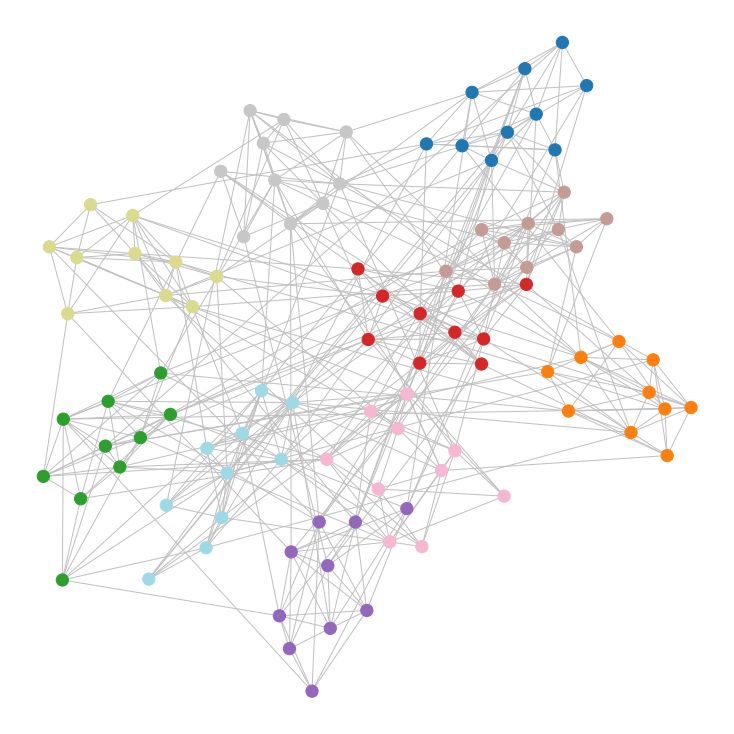

In [544]:
community_id = [partition[node] for node in G.nodes()]

fig = plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    edge_color=['silver'] * len(G.edges()),
    cmap=plt.cm.tab20,
    node_color=community_id,
    node_size=150,
)
# fig.savefig('../figures/partitioned_graph.png', dpi = 500)

I have deliberately not rerun the nx.spring_layout() function so that the layout in our colour-coded plot is the same as in the plot with just blue nodes.